## I. Data Setting

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

tf.__version__

'2.7.1'

In [3]:
print('GPU Information -', tf.test.gpu_device_name(), '\n')

!nvidia-smi

GPU Information - /device:GPU:0 

Thu Nov 24 12:22:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |    720MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

### 2) Image_File Directory Setting
- train_dir
- valid_dir
- test_dir

In [4]:
train_dir = 'split/train' 
valid_dir = 'split/val'
test_dir  = 'split/test'

### 3) ImageDataGenerator( ) & flow_from_directory( )

#### Normalization & Augmentation
- ImageDataGenerator()

#### Resizing & Generator
- flow_from_directory()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = 250

# with augmentation 
train_datagen = ImageDataGenerator(rescale = 1./255,       # Nomalization  
                                   zoom_range = 0.2,       # Augmentation
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest')

# without augmentation
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (img_size,img_size),
                  batch_size = batch_size, 
                  class_mode = 'categorical')

valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (img_size,img_size),
                  batch_size = batch_size,
                  class_mode = 'categorical')

Found 2112 images belonging to 4 classes.
Found 704 images belonging to 4 classes.


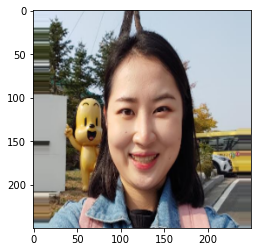

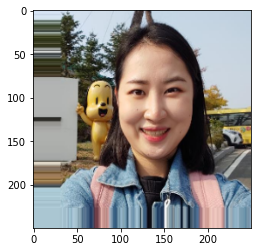

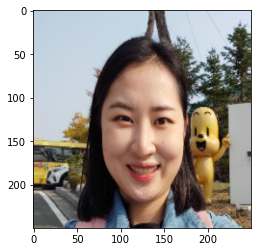

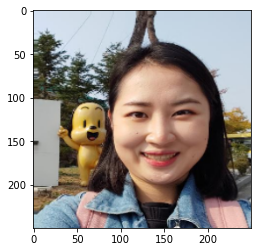

In [6]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

train_Kimchi_dir = train_dir = os.path.join('split/train', 'happy_cropped_image')
fnames = sorted([os.path.join(train_Kimchi_dir, fname) for fname in os.listdir(train_Kimchi_dir)])

# 테스트 이미지 선택
img_path = fnames[0]

# 이미지 읽고 크기 변경
img = image.load_img(img_path, target_size=(250, 250))

# (150, 150, 3) 배열 변환
x = image.img_to_array(img)

# (1, 150, 150, 3) 변환
x = x.reshape((1,) + x.shape)

# 랜덤하게 변환된 이미지 배치 생성
i = 0

for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

### 4) Test train_generator

In [7]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (32, 250, 250, 3)
배치 레이블 크기: (32, 4)


## III. Import VGG-16 Model

### 1) conv_base

In [8]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False, # DNN 제외 
                  input_shape = (250, 250, 3)) # input shape을 여기서 바꾼다 

### 2) Model Information

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

## IV. CNN Keras Modeling

### 1) Model Define
- Feature Extraction & Classification

In [10]:
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

model = models.Sequential()
model.add(conv_base)    # freez 없이
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
# model.add(layers.Dense(256, activation = 'relu',
#                        kernel_regularizer = regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
# model.add(layers.Dense(128, activation = 'relu'),
#                        kernel_regularizer = regularizers.l2(0.00001)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation = 'softmax'))

In [12]:
from IPython.display import SVG
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot

model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))
Utils.plot_model(model,to_file='model.png',show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

AttributeError: 'NoneType' object has no attribute 'create'

### 2) Model Compile
- 모델 학습방법 설정

In [13]:
from tensorflow.keras import optimizers

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

### 3) Model fit
- 모델 학습 수행

In [17]:
!pip install livelossplot
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF

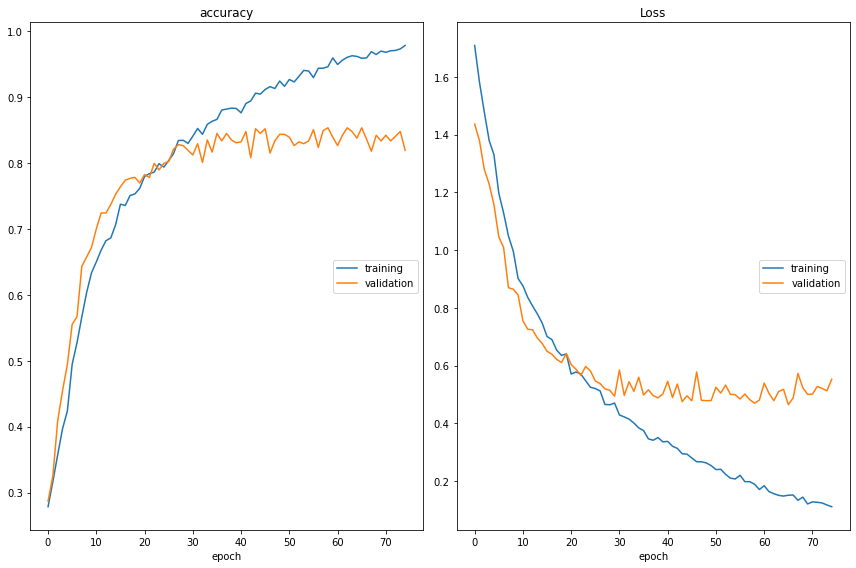

accuracy
	training         	 (min:    0.278, max:    0.979, cur:    0.979)
	validation       	 (min:    0.287, max:    0.854, cur:    0.820)
Loss
	training         	 (min:    0.111, max:    1.708, cur:    0.111)
	validation       	 (min:    0.465, max:    1.436, cur:    0.553)

Epoch 00075: saving model to model_weights.h5
66/66 [==============================] - 36s 534ms/step - loss: 0.1112 - accuracy: 0.9787 - val_loss: 0.5526 - val_accuracy: 0.8196 - lr: 5.0000e-06
CPU times: user 1h 6min 55s, sys: 58.4 s, total: 1h 7min 53s
Wall time: 46min 1s


In [18]:
%%time

epochs = 75
steps_per_epoch = int(train_generator.n//train_generator.batch_size)
validation_steps = int(valid_generator.n//valid_generator.batch_size)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

Hist_dandc = model.fit(train_generator, 
                       steps_per_epoch = steps_per_epoch,
                       epochs = epochs, 
                       validation_data = valid_generator,
                       validation_steps = validation_steps,
                       callbacks=callbacks) 

### 4) 학습 결과 시각화
- Loss Visualization

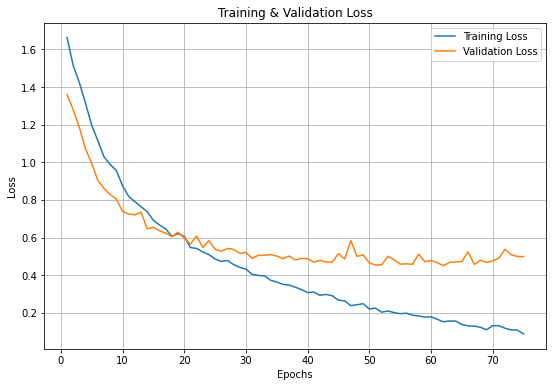

In [29]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.savefig('Training Validation Loss.png')
plt.show()

- Accuracy Visualization

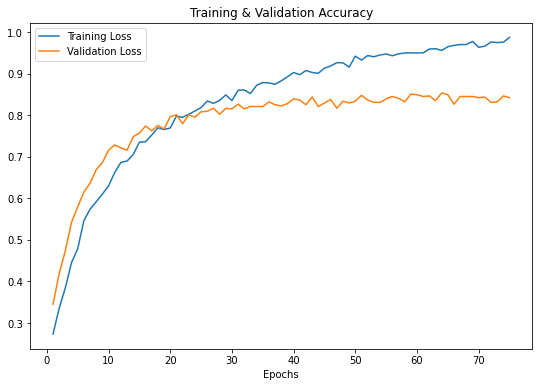

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.savefig('Training Validation Accuracy.png', dpi=100)

### 5) Model Evaluate

- test_generator

In [16]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir, 
                 shuffle = False,
                 target_size = (250, 250),
                 batch_size = 32,
                 class_mode = 'categorical')

Found 704 images belonging to 4 classes.


- Loss & Accuracy

In [17]:
loss, accuracy = model.evaluate(test_generator,
                                steps = validation_steps)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

22/22 [==============================] - 3s 151ms/step - loss: 0.4286 - accuracy: 0.8494
Loss = 0.42863
Accuracy = 0.84943


### 6) Confusion Matrix

In [18]:
import numpy as np

# compute predictions
predictions = model.predict(test_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

In [19]:
from sklearn.metrics import accuracy_score

print('%.8f' % accuracy_score(y_test, y_pred))

0.84943182


In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[124,   8,  21,  23],
       [  0, 171,   3,   2],
       [  5,   1, 158,  12],
       [  8,   6,  17, 145]])

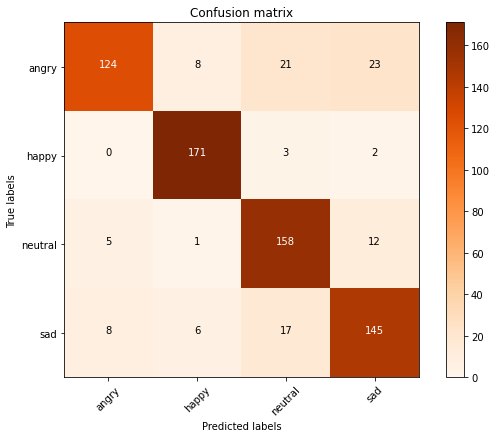

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()

cm = confusion_matrix(y_test, y_pred)
target_names = ['angry', 'happy', 'neutral', 'sad']
plot_confusion_matrix(cm, target_names)

### 7) Classification Report

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, 
                            target_names = ['angry', 'happy', 'neutral', 'sad'],
                            digits = 5))

              precision    recall  f1-score   support

       angry    0.90511   0.70455   0.79233       176
       happy    0.91935   0.97159   0.94475       176
     neutral    0.79397   0.89773   0.84267       176
         sad    0.79670   0.82386   0.81006       176

    accuracy                        0.84943       704
   macro avg    0.85378   0.84943   0.84745       704
weighted avg    0.85378   0.84943   0.84745       704

